In [21]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0,'..')
from src.server.db_api import connect
from src.storage.petastorm_storage_engine import PetastormStorageEngine
from src.readers.opencv_reader import OpenCVReader
from src.catalog.models.df_metadata import DataFrameMetadata
from src.storage.petastorm_storage_engine import PetastormStorageEngine, AbstractStorageEngine
from src.catalog.models.df_column import DataFrameColumn
from src.models.storage.batch import Batch
from src.catalog.column_type import ColumnType, NdArrayType
from src.readers.abstract_reader import AbstractReader
from src.readers.petastorm_reader import PetastormReader
from typing import Iterator
import os
import ffmpeg
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Petastorm

- Read a video using OpenCVReader
- Write video to petastorm storage using PetastormStorageEngine
- Read the video using PetastormStorageEngine

In [4]:
one_min_video = "/home/akshay/Downloads/pallof.mp4"
thirty_sec_video = "/home/akshay/Downloads/30secseinfeld.mkv"

In [5]:
%%time
# trying out time functionality
for i in range(100):
    a = 78 ** 90

CPU times: user 90 µs, sys: 34 µs, total: 124 µs
Wall time: 135 µs


In [1]:
table_info = DataFrameMetadata("dataset", 'dataset')
column_1 = DataFrameColumn("id", ColumnType.INTEGER, False)
column_2 = DataFrameColumn("data", ColumnType.NDARRAY, False, NdArrayType.UINT8, [1280, 720, 3])
table_info.schema = [column_1, column_2]
petastorm = PetastormStorageEngine()
petastorm.create(table_info)

In [ ]:
%%time

opencv_reader = OpenCVReader(one_min_video, 30000000)
for batch in opencv_reader.read():
    petastorm.write(table_info, batch)

In [19]:
class FFmpegStorageEngine(AbstractStorageEngine):
    
    """
    Thread-unsafe storage engine that writes an entire sequence of frames out as a video, sequentially
    A video is a _baked_ format
    TODO: allow access to multiple tables at the same time (not multithreaded access to the same table)
        - This can be achieved using a dictionary mapping from table name to the corresponding process
    """
    
    STORAGE_PATH = "ffmpeg_data"
    STORAGE_FORMAT = "mp4"
    
    def __init__(self):
        self.location = None
        self.process = None
    
    def _file_url(self, table: DataFrameMetadata):
        return "/".join([self.STORAGE_PATH, table.file_url])
    
    def create(self, table: DataFrameMetadata):
            if not os.path.exists(self.STORAGE_PATH):
                os.makedirs(self.STORAGE_PATH)
            # assert: directory present for storing files
            file_location = self._file_url(table)
            
            # create empty file in filesystem
            open(file_location, "w").close()
            
    def open_write(self, table: DataFrameMetadata):
        assert self.location == None and self.process == None
        file_location = self._file_url(table)
        width, height = table.resolution
        self.process = (
            ffmpeg
            .input('pipe:', format='rawvideo', pix_fmt='bgr24', s='{}x{}'.format(width, height))
            .output(file_location + "." + self.STORAGE_FORMAT, format=self.STORAGE_FORMAT, crf='18')
            .overwrite_output()
            .run_async(pipe_stdin=True)
        )
    
    def write(self, table: DataFrameMetadata, rows: Batch):
        height, width = table.resolution
        frames = rows.frames['data'].values
        
        for frame in frames:
        
            self.process.stdin.write(
                frame
                .astype(np.uint8)
                .tobytes()
            )
            
    
    def open_read(self, table: DataFrameMetadata):
        assert self.process == None and self.location == None
        file_location = self._file_url(table)
        width, height = table.resolution
        self.process = (
            ffmpeg
            .input(file_location + "." + self.STORAGE_FORMAT)
            .output('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'.format(width, height))
            .run_async(pipe_stdout=True)
        )
                
            
    def read(self, table, batch_mem_size=30000000, predicate=None) -> Iterator[Batch]:
        """
        table: DataframeMetadata
        pos: frame number 
        select-expr: ffmpeg select expression
        """ 
        
        i = 0
        data = []
        width, height = table.resolution
        row_size = width * height * 3
        
        while True:
            in_bytes = self.process.stdout.read(width * height * 3)
            
            if not in_bytes:
                break
            
            if predicate and not predicate(i):
                i += 1
                continue
            
            in_frame = (
                np
                .frombuffer(in_bytes, np.uint8)
                .reshape([height, width, 3])
            )
            
            data.append({'id': i, 'data': in_frame})
            
            if len(data) * row_size > batch_mem_size:
                yield Batch(pd.DataFrame(data))
                data = []
                
            i += 1
        
        if len(data) > 0:
            yield Batch(pd.DataFrame(data))
                
        
    
    def _open(self, table):
        pass
    
    def _close(self, table):
        pass
    
    def close_write(self, table):
        # use this to stop the async ffmpeg process
        self.process.stdin.close()
        self.process.wait()
        self.process = None
        self.location = None
        
    def close_read(self, table):
        self.process.wait()
        self.process = None
        self.location = None
    
    def _read_init(self, table):
        # use this to start the async ffmpeg read process
        pass
        

In [27]:
%%time
opencv_reader = OpenCVReader(one_min_video, 30000000)
ffengine = FFmpegStorageEngine()
seinfeldtable = DataFrameMetadata("oneminseinfeld", "seinfeldvideo")
seinfeldtable.resolution = (1280, 720)
ffengine.create(seinfeldtable)
ffengine.open_write(seinfeldtable)
for batch in opencv_reader.read():
    ffengine.write(seinfeldtable, batch)
ffengine.close_write(seinfeldtable)

ffmpeg version n4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11.1.0 (GCC)
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librav1e --enable-librsvg --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxcb --enable-libxml2 --enable-libxvid -

CPU times: user 11.9 s, sys: 1.56 s, total: 13.5 s
Wall time: 44.6 s


frame= 1118 fps= 25 q=-1.0 Lsize=    7245kB time=00:00:44.60 bitrate=1330.7kbits/s speed=   1x    
video:7231kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.187683%
[libx264 @ 0x55fa27ecc240] frame I:6     Avg QP:10.18  size: 98058
[libx264 @ 0x55fa27ecc240] frame P:315   Avg QP:14.86  size: 14854
[libx264 @ 0x55fa27ecc240] frame B:797   Avg QP:18.03  size:  2681
[libx264 @ 0x55fa27ecc240] consecutive B-frames:  3.0%  2.1% 11.5% 83.4%
[libx264 @ 0x55fa27ecc240] mb I  I16..4: 22.4% 34.0% 43.5%
[libx264 @ 0x55fa27ecc240] mb P  I16..4:  3.6%  5.0%  1.6%  P16..4: 25.2% 11.8%  6.4%  0.0%  0.0%    skip:46.4%
[libx264 @ 0x55fa27ecc240] mb B  I16..4:  0.5%  0.5%  0.0%  B16..8: 22.2%  2.4%  0.3%  direct: 0.8%  skip:73.3%  L0:42.5% L1:52.6% BI: 4.9%
[libx264 @ 0x55fa27ecc240] 8x8 transform intra:46.7% inter:64.8%
[libx264 @ 0x55fa27ecc240] coded y,u,v intra: 38.2% 21.2% 16.7% inter: 7.7% 4.8% 3.5%
[libx264 @ 0x55fa27ecc240] i16 v,h,dc,p: 45% 29% 21%  6%
[libx264

In [ ]:
%%time
seinfeldtable = DataFrameMetadata("oneminseinfeld", "seinfeldvideo")
seinfeldtable.resolution = (1280, 720)
f2fengine = FFmpegStorageEngine()
f2fengine.open_read(seinfeldtable)
for images in f2fengine.read(seinfeldtable, predicate=lambda x: x % 1000 == 0):
    image_arrays = images.frames['data'].values
f2fengine.close_read(seinfeldtable)

ffmpeg version n4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11.1.0 (GCC)
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librav1e --enable-librsvg --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxcb --enable-libxml2 --enable-libxvid -

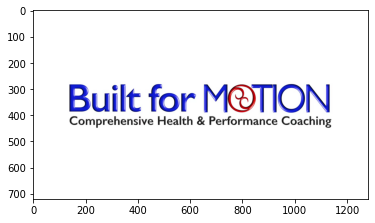

In [25]:
plt.imshow(image_arrays[0])

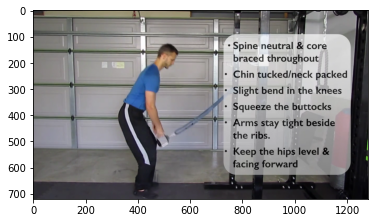

In [26]:
plt.imshow(image_arrays[1])